In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)
    def forward(self, X, *args):
        X.shape
        
        X = self.embedding(X)
        print(X.size)
        X = X.permute(1, 0, 2)
        print(X.size)
        output, state = self.rnn(X)
        return output, state

In [3]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape
state.shape

<built-in method size of Tensor object at 0x1058ebc70>
<built-in method size of Tensor object at 0x1520b3950>


torch.Size([2, 4, 16])

In [4]:
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]
    
    def forward(self, X, state):
        X = self.embedding(X)
        print(X.size)
        X = X.permute(1, 0, 2)
        print(X.size)
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        print(X_and_context)
        output, state = self.rnn(X_and_context, state)
        print(output)
        output = self.dense(output).permute(1, 0, 2)
        print(output)
        return output, state

In [5]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape
state.shape

<built-in method size of Tensor object at 0x15204b4a0>
<built-in method size of Tensor object at 0x15204be00>
<built-in method size of Tensor object at 0x1058d7040>
<built-in method size of Tensor object at 0x15204be00>
tensor([[[ 1.2138e+00,  8.9872e-01,  4.4591e-01, -1.1194e+00,  5.8268e-01,
           2.0145e-01,  4.4862e-01,  3.1424e-01, -4.6463e-01, -3.8785e-03,
           2.0352e-01, -1.9595e-01, -1.8877e-01,  2.8554e-02,  2.0585e-01,
          -1.7636e-01,  3.1060e-01, -3.3057e-01,  2.5305e-01,  1.6652e-01,
           2.1164e-01,  2.5128e-01, -8.1989e-02, -8.4802e-04],
         [ 1.2138e+00,  8.9872e-01,  4.4591e-01, -1.1194e+00,  5.8268e-01,
           2.0145e-01,  4.4862e-01,  3.1424e-01, -4.6463e-01, -3.8785e-03,
           2.0352e-01, -1.9595e-01, -1.8877e-01,  2.8554e-02,  2.0585e-01,
          -1.7636e-01,  3.1060e-01, -3.3057e-01,  2.5305e-01,  1.6652e-01,
           2.1164e-01,  2.5128e-01, -8.1989e-02, -8.4802e-04],
         [ 1.2138e+00,  8.9872e-01,  4.4591e-01, -1.11

torch.Size([2, 4, 16])

In [6]:
def sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

In [7]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [8]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [9]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [10]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [11]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1], ))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f}'
          f'tokens/sec on {str(device)}')

In [12]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

In [13]:
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

In [14]:
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
print(net)

EncoderDecoder(
  (encoder): Seq2SeqEncoder(
    (embedding): Embedding(184, 32)
    (rnn): GRU(32, 32, num_layers=2, dropout=0.1)
  )
  (decoder): Seq2SeqDecoder(
    (embedding): Embedding(201, 32)
    (rnn): GRU(64, 32, num_layers=2, dropout=0.1)
    (dense): Linear(in_features=32, out_features=201, bias=True)
  )
)


loss 0.019, 14478.7tokens/sec on cpu


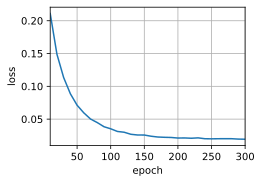

In [15]:
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [16]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_cocab, num_steps,
                    device, save_attention_weights=False):
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [17]:
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [18]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

In [19]:
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, ',
          f'bleu {bleu(translation, fra, k=2):.3f}')

<built-in method size of Tensor object at 0x1525464f0>
<built-in method size of Tensor object at 0x152546e00>
<built-in method size of Tensor object at 0x152546d60>
<built-in method size of Tensor object at 0x152546a90>
tensor([[[ 0.8106, -0.6988,  0.0032,  0.0862, -1.2587, -0.6633,  0.2425,
           0.4189,  0.1711,  0.1278, -0.4198, -2.2580, -0.0491,  0.3116,
          -1.7015, -1.4841, -1.0343,  1.1245,  0.9093, -0.2917,  0.1858,
          -0.4663,  0.8404, -0.0680, -0.8339,  0.4894, -0.0552, -1.0674,
          -0.5742, -0.0080,  1.4084,  0.8964, -0.1008, -1.0000, -1.0000,
          -0.8474,  0.7471,  0.6608, -0.9964, -0.9999, -1.0000, -0.4858,
          -0.9788, -0.9981,  1.0000,  1.0000, -0.8257,  1.0000,  1.0000,
           1.0000, -0.9894,  1.0000,  1.0000,  1.0000, -0.8702, -1.0000,
          -1.0000,  1.0000,  0.9848, -0.9982,  0.9776,  0.9972, -0.8819,
          -0.9991]]], grad_fn=<CatBackward0>)
tensor([[[ 0.9995,  0.9678, -0.9992, -0.8474, -0.9781,  0.6623,  0.9301,
    